In [2]:
import time
import locale
from datetime import datetime
from dateutil.relativedelta import relativedelta
from typing import List, Tuple
import pandas as pd
import numpy as np

# PROGRESS BAR
from tqdm import tqdm

# MODEL OPTIMIZATION 
from scipy.optimize import minimize, basinhopping

# DATA VISUALIZATION
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.ticker as ticker
from matplotlib.font_manager import FontProperties
import seaborn as sns

# WEB SCRAPING
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup
import requests

# Kase data scraping class for Ministry of Finance and NBRK Government Securities

In [4]:
class KaseScraper:
    """
    Web scraper for the Kazakhstan Stock Exchange (KASE) website.

    Attributes:
        URL (str): Base URL for KASE website.
        MINFIN_XPATH (str): XPATH expression for the link to "Ценные бумаги Министерства финансов Республики Казахстан".
        NBRK_XPATH (str): XPATH expression for the link to "Ценные бумаги ГУ «Национальный Банк Республики Казахстан»".
        TABLE_HEADER (List[str]): Table column headers.
    """

    URL = "https://kase.kz/ru/gsecs/"
    MINFIN_XPATH = '//a[@data-typ="1" and @title="Ценные бумаги Министерства финансов Республики Казахстан"]'
    NBRK_XPATH = '//a[@data-typ="2" and @title="Ценные бумаги ГУ «Национальный Банк Республики Казахстан»"]'
    TABLE_HEADER = ["ISIN", "Ticker", "URL", "Bond's name", "Currency", "Offering, mln KZT", "Yield, %", "Maturity"]

    def __init__(self, driver=None):
        """
        Initialize the KaseScraper class.

        Parameters:
            driver: Selenium WebDriver instance. If not provided, a new Chrome WebDriver will be created.
        """
        options = webdriver.ChromeOptions()
        options.add_argument('--headless')
        self.driver = driver if driver else webdriver.Chrome()

    def __enter__(self):
        """
        Enter method for context management.

        Returns:
            self: The current KaseScraper object.
        """
        return self

    def __exit__(self, exc_type, exc_value, traceback):
        """
        Exit method for context management. Quits the WebDriver.

        Parameters:
            exc_type: The exception type.
            exc_value: The exception value.
            traceback: The traceback.

        Returns:
            None
        """
        self.driver.quit()

    def extract(self) -> pd.DataFrame:
        """
        Extract data by navigating to each table and scraping the data.

        Returns:
            pd.DataFrame: The concatenated DataFrame containing extracted data.
        """
        with self:
            minfin_df = self.navigate_and_scrape(self.URL, self.MINFIN_XPATH)
            nbrk_df = self.navigate_and_scrape(self.URL, self.NBRK_XPATH)
            return pd.concat([minfin_df, nbrk_df], ignore_index=True)

    def navigate_and_scrape(self, url: str, xpath: str) -> pd.DataFrame:
        """
        Navigate to the table page and scrape the data.

        Parameters:
            url (str): The URL to navigate to.
            xpath (str): The XPATH expression for the link to the table.

        Returns:
            pd.DataFrame: The DataFrame containing scraped data.
        """
        self.driver.get(url)
        self.navigate_to_table(xpath)
        return self.scrape_table()

    def navigate_to_table(self, xpath: str) -> None:
        """
        Navigate to the table data by clicking on the specified link.

        Parameters:
            xpath (str): The XPATH expression for the link to the table.

        Returns:
            None
        """
        wait = WebDriverWait(self.driver, 10)
        print("Navigating to table data...")
        table_tab = wait.until(EC.element_to_be_clickable((By.XPATH, xpath)))
        table_tab.click()
        time.sleep(1)
        show_more = wait.until(EC.element_to_be_clickable((By.XPATH,
                            '//a[@class="sorting_table_show_all" and @data-table="sorting_table_gsecs_main"]'
                            )))
        show_more.click()
        time.sleep(1)

    def scrape_table(self) -> pd.DataFrame:
        """
        Scrape the table data.

        Returns:
            pd.DataFrame: The DataFrame containing scraped data.
        """
        page_source = self.driver.page_source
        soup = BeautifulSoup(page_source, 'html.parser')
        url = "https://kase.kz"
        
        print("Scraping table data...")
        
        table_id = 'sorting_table_gsecs_main'
        table = soup.find('table', {'id': table_id})
        rows = table.find_all('tr')
        
        data = []
        
        for row in tqdm(rows[1:], desc="Scraping Rows", unit=" row"):  # Skip the header row
            cells = row.find_all('td')
            row_data = []
            for cell in cells:
                row_data.append(cell.get_text(strip=True))
                link = cell.find('a')
                if link is not None:
                    link = url + str(link['href'])
                    bond_specifics = self.scrape_bond_specifics(link)
                    row_data.append(link)
                    row_data.append(bond_specifics)
            data.append(row_data)
            
        print("Scraping complete. ", len(rows) - 1, "rows collected.")
        
        return pd.DataFrame(data, columns=self.TABLE_HEADER)

    @staticmethod
    def scrape_bond_specifics(url: str) -> str:
        """
        Scrape specific bond information from the given URL.

        Parameters:
            url (str): The URL to scrape.

        Returns:
            str: The desired text scraped from the URL.
        """
        response = requests.get(url)
        if response.status_code == 200:
            soup = BeautifulSoup(response.content, 'html.parser')
            label_div = soup.find('div', class_='info-table__cell', text='Наименование облигации:')
            value_div = label_div.find_next_sibling('div', class_='info-table__cell')
            desired_text = value_div.get_text(strip=True)
            return desired_text
        else:
            return "None"

# Yield Curve class for data preprocessing and modeling.

In [258]:
class YieldCurve:
    def __init__(self, raw_df: pd.DataFrame):
        """
        Initialize the YieldCurve class.

        Parameters:
            raw_df (pd.DataFrame): The raw data DataFrame.
        """
        self.df = raw_df.copy(deep=True)
        self.filter_df = None
        self.maturities = []
        self.yields = []
        self.params = []
        self.bond_names = ['купонные МЕУКАМ', 'купонные МЕОКАМ', 'дисконтные ноты']
        self.curve_df = None

    def preprocess_data(self) -> None:
        """
        Preprocess the raw data DataFrame to prepare it for analysis.
        """
        self._convert_to_float("Offering, mln KZT")
        self._convert_to_float("Yield, %")
        self._convert_maturity()

    def filter_bonds(self) -> None:
        """
        Filter the DataFrame to include only relevant bonds based on criteria.
        """
        filter_df = self.df[self.df["Bond's name"].isin(self.bond_names)]
        filter_df = filter_df[filter_df["Currency"] == "KZT"]
        filter_df["Yield, %"] = filter_df["Yield, %"].replace({0.0: float('nan'), 0.1: float('nan')})
        filter_df = filter_df[filter_df["Yield, %"] > 7]
        filter_df = filter_df[filter_df["Maturity"] <= 6]
        filter_df = filter_df.sort_values(by=["Maturity"], ascending=True)
        filter_df = filter_df.reset_index(drop=True)
        self.filter_df = filter_df.copy()

    def _convert_to_float(self, column_name: str) -> None:
        """
        Convert the specified column in the DataFrame to float type.

        Parameters:
            column_name (str): Name of the column to be converted.
        """
        self.df[column_name] = self.df[column_name].replace({"–": "0"}).str.replace(",", ".").str.replace(" ", "").astype(float)

    def _convert_maturity(self) -> None:
        """
        Convert the 'Maturity' column in the DataFrame to a numerical format.
        """
        self.df["Maturity"] = self.df["Maturity"].str.extract(r"(\d+)").astype(float) / 360

    def predict_yield_curve(self) -> None:
        """
        Predict the yield curve using Nelson-Siegel model and optimize parameters.
        """
        maturities = self.filter_df["Maturity"]
        self.yields = self.filter_df["Yield, %"]
        m = np.linspace(0.001, 15, 100)
            
        # Initial parameters
        initial_guess = (24.5, 0.0, 0.0, maturities.mean(), 0.0, 0.0, 0.0)

        bounds = [(24.5, 24.5), (None, None), (None, None), (maturities.mean(), maturities.mean()), (None, None), (None, None), (None, None)]
        minimizer_kwargs = {"args": (maturities,), "bounds": bounds}
        
        best_result = {'x': None, 'fun': np.inf}
        def callback(x, f, accept):
            nonlocal best_result
            if round(f, 2) < round(best_result['fun'], 2):
                best_result['x'] = x
                best_result['fun'] = f
                print(f'Found global minimum: x={x} f={f}')


        # Basinhopping optimization
        optimized_params = basinhopping(self.error_function, 
                                        initial_guess, 
                                        minimizer_kwargs=minimizer_kwargs, 
                                        niter=20, T=0.1, 
                                        stepsize=0.5, disp=False, callback=callback).x


        # Yield curve modeling
        prediction = self.nelson_siegel(m, *optimized_params)

        self.params = optimized_params
        self.curve_df = pd.DataFrame({"Maturity": m, "Curve": prediction})
    
    @staticmethod
    def nelson_siegel(m: List[float], beta0: float, beta1: float, beta2: float, 
                      tau: float, g1: float, g2: float, g3: float) -> np.ndarray:
        """
        Calculate the Nelson-Siegel model prediction for the given maturities.

        Parameters:
            m (List[float]): List of maturities.
            beta0 (float): Parameter beta0 of the Nelson-Siegel model.
            beta1 (float): Parameter beta1 of the Nelson-Siegel model.
            beta2 (float): Parameter beta2 of the Nelson-Siegel model.
            tau (float): Parameter tau of the Nelson-Siegel model.
            g1 (float): Parameter g1 of the Nelson-Siegel model.
            g2 (float): Parameter g2 of the Nelson-Siegel model.
            g3 (float): Parameter g3 of the Nelson-Siegel model.

        Returns:
            np.ndarray: The Nelson-Siegel model prediction for the given maturities.
        """
        return beta0 + beta1 * ((tau/m) * ((1 - np.exp(-m / tau)))) + beta2 * ((tau/m) * ((1 - np.exp(-m / tau)))) - (beta2 * np.exp(-m / tau)) + g1 * np.exp(-(m**2 / 2)) + g2 * np.exp(-((m - 1)**2 / 2)) + g3 * np.exp(-((m-2)**2 / 2))

    def error_function(self, params: Tuple[float, float, float, float, float, float, float], m: List[float]) -> float:
        """
        Calculate the error function for the Nelson-Siegel model.

        Parameters:
            params (Tuple[float, float, float, float, float, float, float]): Model parameters.
            m (List[float]): List of maturities.

        Returns:
            float: The error function value.
        """
        return sum((self.nelson_siegel(m, *params) - self.yields) ** 2)

    def download_data(self, file_path: str, format: str = "excel") -> None:
        """
        Download the filtered DataFrame to a file.

        Parameters:
            file_path (str): File path for saving the data.
            format (str): File format for saving the data (csv or excel).

        Returns:
            None
        """
        if format == "csv":
            self.filter_df.to_csv(file_path, index=False)
            print(f"Saved to {file_path}.")
        elif format == "excel":
            self.filter_df.to_excel(file_path, index=False)
            print(f"Saved to {file_path}.")
        else:
            raise ValueError("Unsupported file format. Please use 'csv' or 'excel'.")

# Yield curve visualization class

In [22]:
class YCVisualizer:
    PRIM_COLORS = {
        "yellow": "#ffb600",
        "tangerine": "#eb8c00",
        "orange": "#d04a02",
        "rose": "#db536a",
        "digital-rose": "#d93954",
        "red": "#e0301e",
        "lo-2": "#feb791", # Light orange 2
        "lr-2": "#f1bac3", # Light red 2
        "ly-2": "#ffecbd", # light yellow 2
        "lt-2": "#ffdca9" # Light tangerine 2
    }
    SEC_COLORS ={
        "black": "#000000",
        "darker-grey": "#111111",
        "dark-grey": "#2d2d2d",
        "medium-grey": "#464646",
        "grey": "#7d7d7d",
        "light-grey": "#dedede"
    }
    
    def __init__(self, df: pd.DataFrame, curve_df: pd.DataFrame):
        """
        Initialize the YCVisualizer class.

        Parameters:
            df (pd.DataFrame): The preprocessed DataFrame.
            curve_df: (pd.DataFrame): Nelson-Siegel predictions
        """
        self.df = df.copy(deep=True)
        self.curve_df = curve_df.copy(deep=True)

    def kase_plot(self, 
                  size: Tuple[int, int] = (12, 6),
                  xlimits: Tuple[float, float] = (-0.1, 5),
                  ylimits: Tuple[float, float] = (11, 17),
                  lw: int = 2,
                  title: str = "Безрисковая кривая доходности ГЦБ на 28.07.2023",
                  xlab: str = "Кол-во лет до погашения",
                  ylab: str = "Доходность",
                  line_color: str = PRIM_COLORS['yellow'],
                  hue: str = "Bond's name",
                  plot_hue: bool = True,
                  download: bool = False,
                  one_year = False,
                  vlines=True,
                  font_size_ticks = 12,
                  font_size_labs = 12,
                  img_name="Безрисковая кривая.png"
                 ) -> None:
        """
        Plot the KASE yield curve.

        Parameters:
            size (Tuple[int, int]): Size of the plot (width, height).
            xlimits (Tuple[float, float]): Limits for the x-axis.
            ylimits (Tuple[float, float]): Limits for the y-axis.
            lw (int): Line width.
            title (str): Title of the plot.
            xlab (str): Label for the x-axis.
            ylab (str): Label for the y-axis.
            line_color (str): Color of the yield curve line.
            hue (str): Column name for grouping data points by hue.
            plot_hue (bool): If True, plot data points with different hues.
            download (bool): If True, save the plot as an image.

        Returns:
            None
        """
        locale.setlocale(locale.LC_ALL, 'nl_NL')
        matplotlib.rc('xtick', labelsize=font_size_ticks) 
        matplotlib.rc('ytick', labelsize=font_size_ticks) 
        matplotlib.rcParams['font.family'] = "Arial"
        plt.rcParams['xtick.color'] = YCVisualizer.SEC_COLORS['black']
        plt.rcParams['ytick.color'] = YCVisualizer.SEC_COLORS['black']
        
        plot_df = self.df
        curve_df = self.curve_df
        single_point = pd.DataFrame({"Maturity": [0.0], "Curve": [16.75]})

        fig, ax = plt.subplots(figsize=size, zorder=1)
        
        # UNCOMMENT BELOW TO REPLACE DEFAULT X-AXIS TICK MARKS WITH YEARS OR MONTHS
#         if one_year:
#             strings, values = self.days_to_succeeding_months()
#             custom_tick_positions = [days/360.0 for days in values]
#             custom_tick_labels = [s for s in strings]
        
#         else:
#             strings, values = self.days_to_next_years()
#             custom_tick_positions = [days/360.0 for days in values]
#             custom_tick_labels = [s for s in strings]
        
        font_props = FontProperties(weight='bold')
        
        #ax.set_xticks(custom_tick_positions, custom_tick_labels, fontweight='bold')
        ax.yaxis.set_major_locator(ticker.MultipleLocator(base=0.5))
        
        for label in ax.get_yticklabels():
            label.set_fontproperties(font_props)
            
        for label in ax.get_xticklabels():
            label.set_fontproperties(font_props)

        
        # SET Y-axis format to have 2 decimal points and % sign
        ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: locale.format("%.2f", x) + "%"))
        
        # PLOT VERTICAL LINES
        if vlines:
            vertical_lines = {
                #0.0: {'color': YieldCurve.SEC_COLORS['black'], 'label': 'O/N'},
                30/360.0: {'color': YCVisualizer.SEC_COLORS['darker-grey'], 'label': '30 days'},
                60/360.0: {'color': YCVisualizer.SEC_COLORS['darker-grey'], 'label': '60 days'},
                90/360.0: {'color': YCVisualizer.SEC_COLORS['darker-grey'], 'label': '90 days'},
                180/360.0: {'color': YCVisualizer.SEC_COLORS['darker-grey'], 'label': '180 days'},
                360/360.0: {'color': YCVisualizer.SEC_COLORS['darker-grey'], 'label': '1 year'}
            }

            for x_val, line_props in vertical_lines.items():
                line = plt.axvline(x=x_val, color=YCVisualizer.SEC_COLORS['darker-grey'], linestyle=':', lw=1.4)
        
        # PLOT SCATTER POINTS
        if plot_hue:
            PRIM_COLORS = YCVisualizer.PRIM_COLORS
            palette = [PRIM_COLORS["digital-rose"], PRIM_COLORS["tangerine"], PRIM_COLORS["orange"]]
            ax = sns.scatterplot(data=plot_df, 
                                 x='Maturity', y='Yield, %', 
                                 hue=hue, 
                                 style=hue,
                                 markers=True,
                                 palette=palette, 
                                 ax=ax,
                                 #clip_on=False,
                                 s=50, zorder=3)
        
        # PLOT YIELD CURVE
        ax = sns.lineplot(x='Maturity', y='Curve', 
                          data=curve_df, 
                          color=line_color, 
                          lw=lw, ax=ax, zorder=2)
        
        # PLOT BASE RATE SCATTER POINT
        ax.scatter(single_point['Maturity'], 
                   single_point['Curve'], 
                   marker='o', 
                   color=YCVisualizer.SEC_COLORS["medium-grey"], 
                   clip_on=False, zorder=3)

        # ADD TITLE
        plt.title(title, fontsize=14, loc="left", color=YCVisualizer.SEC_COLORS['grey'], fontweight='bold')
        
        # SET X, Y axis ranges
        ax.set_ylim(ylimits[0], ylimits[1])
        ax.set_xlim(xlimits[0], xlimits[1])
        
        # SET X, Y axis labels
        ax.set_xlabel(xlab, fontsize=font_size_labs, color=YCVisualizer.SEC_COLORS['black'], fontweight='bold')
        ax.set_ylabel(ylab, fontsize=font_size_labs, color=YCVisualizer.SEC_COLORS['black'], fontweight='bold')
        
        # REMOVE TOP, RIGHT PLOT BORDERS
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        # CHANGE AXIS COLORS
        ax.spines['bottom'].set_color(YCVisualizer.SEC_COLORS['black']) 
        ax.spines['left'].set_color(YCVisualizer.SEC_COLORS['black']) 
        
        # TURN OFF GRIDLINES
        ax.grid(False)
        
        # ADD LEGEND
        ax.legend(loc='lower center', bbox_to_anchor=(0.4, -0.20), 
                  fontsize=9, edgecolor='white', ncol=3,
                  handlelength=0.7, handletextpad=0.15, labelspacing=0.15, columnspacing=0.7)
        
        # DOWNLOAD FIGURE
        if download:
            plt.savefig(img_name, dpi=1000, bbox_inches='tight')
        
        plt.show()
    
    @staticmethod
    def days_to_succeeding_months():
        """
            Get the strings and values for custom x-axis tick marks based on succeeding months.

            Returns:
                Tuple[List[str], List[int]]: List of strings for tick labels, list of values for tick positions.
        """
        locale.setlocale(locale.LC_TIME, 'rus')

        current_date = datetime.now()
        one_year_from_now = current_date + relativedelta(years=1)

        cumulative_days = 0
        strings = []
        values = []

        while current_date <= one_year_from_now:
            next_month = current_date + relativedelta(months=1)
            days_difference = (next_month.replace(day=1) - current_date).days
            cumulative_days += days_difference
            
            if next_month.month == 1:
                year_str = str(next_month.year)
                strings.append(year_str)
                values.append(cumulative_days)
            else:
                month_year_str = next_month.strftime('%b')
                strings.append(month_year_str)
                values.append(cumulative_days)

            current_date = next_month.replace(day=1)

        return strings, values
    
    @staticmethod
    def days_to_next_years():
        """
        Get the strings and values for custom x-axis tick marks based on next years.

        Returns:
            Tuple[List[str], List[int]]: List of strings for tick labels, list of values for tick positions.
        """
        locale.setlocale(locale.LC_TIME, 'rus')

        current_date = datetime.now()
        five_years_from_now = current_date + relativedelta(years=4)

        cumulative_days = 0
        strings = []
        values = []

        while current_date <= five_years_from_now:
            next_year = current_date + relativedelta(years=1)
            days_difference = (next_year.replace(month=1, day=1) - current_date).days
            cumulative_days += days_difference
            
            current_date = next_year.replace(month=1, day=1)
            year_str = str(current_date.year)
            strings.append(year_str)
            values.append(cumulative_days)

        return strings, values

# Initialize Kase Scraper and extract data

In [6]:
with KaseScraper() as scraper:
    raw_data = scraper.extract()

Navigating to table data...
Scraping table data...


Scraping Rows: 100%|███████████████████████████████████████████████████████████████| 119/119 [00:47<00:00,  2.52 row/s]


Scraping complete.  119 rows collected.
Navigating to table data...
Scraping table data...


Scraping Rows: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.96 row/s]


Scraping complete.  2 rows collected.


# Initialize Yield Curve class instance, preprocess and filter data, fit a yield curve

In [241]:
yc = YieldCurve(raw_data)
yc.preprocess_data()
yc.filter_bonds()
yc.predict_yield_curve()

Found global minimum: x=[ 2.45000000e+01 -1.82611952e-02 -3.85304762e+01  2.85867209e+00
 -8.19662904e+00  1.12933474e+00 -1.75343716e+00] f=50.86274792090067


In [4]:
f_df = pd.read_excel("Plot_Data.xlsx")
c_df = pd.read_excel("Curve_Data.xlsx")

# Visualize the yield curve

In [23]:
visualizer = YCVisualizer(f_df, c_df)

C:\Users\asabet001\AppData\Local\Temp\ipykernel_10040\425931645.py:109: DeprecationWarning: This method will be removed in a future version of Python. Use 'locale.format_string()' instead.
  ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: locale.format("%.2f", x) + "%"))
C:\Users\asabet001\AppData\Local\Temp\ipykernel_10040\425931645.py:109: DeprecationWarning: This method will be removed in a future version of Python. Use 'locale.format_string()' instead.
  ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: locale.format("%.2f", x) + "%"))


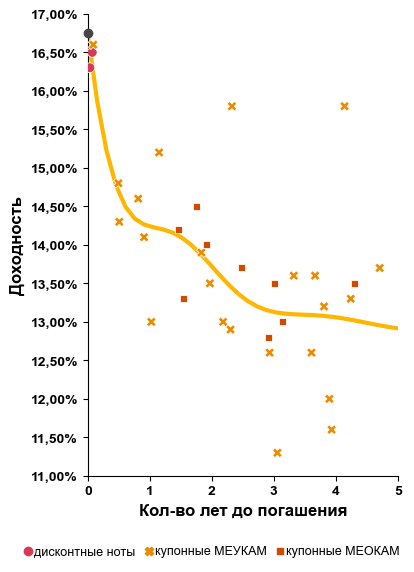

In [25]:
visualizer.kase_plot(title="", 
                     size=(4, 6), 
                     xlimits=(0, 5), 
                     lw=3, 
                     download=True, 
                     vlines=False)

C:\Users\asabet001\AppData\Local\Temp\ipykernel_10040\425931645.py:109: DeprecationWarning: This method will be removed in a future version of Python. Use 'locale.format_string()' instead.
  ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: locale.format("%.2f", x) + "%"))
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


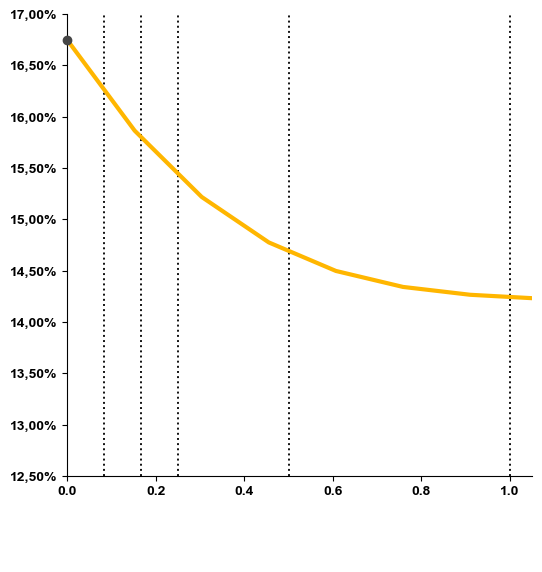

In [26]:
visualizer.kase_plot(title="", 
                     xlab="", 
                     ylab="", 
                     xlimits=(0, 1.05), 
                     size=(6,6), lw=3, 
                     ylimits=(12.5, 17), 
                     plot_hue=False, 
                     download=True, 
                     one_year=True, 
                     img_name="Yield-curve.png")

# Download data

In [259]:
yc.download_data("test.xlsx", format="excel")